# Defining the question

Before getting hands on the dataset, We should define the question on it so that we can know what should we deal with it and how to qualify or disqulify potential solutions to the specific problem. Obviously, this dataset is base on an actual Business Scenario of **HOW TO ORIENTATE THE CUSTOMER GROUP AND MAKE BETTER SEGMENTATION FOR THE SAKE OF ACCUATE SALES STRATEGY.**  
The questions we are going to find out are :
1. What's the Gender/age/Annual Income/Spending Score distribution of Customers in this mall？
2. Is there any specific groups showing higher value to the mall?If it is, what do you suggest?
3. Does the customer who gets high level of income means that he/she spend more in the mall?
4. How to make Customer Segmentation according to their performance on age & annual income & spending score?
5. If using K-means, how to evaluate the accuracy of the final clustering result?
    * Inertia
    * Silhouette score


# Data exploration

## Libraries Importing

In [26]:
# data loading and processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as sci #using the pearson

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# model training and machine learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # evaluate the model

# file operation
import os
print(os.listdir("../input"))

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

['Mall_Customers.csv']


## Data Overview

In [27]:
# read the data and store data in DataFrame titled Mall_data
Mall_data = pd.read_csv(r"../input/Mall_Customers.csv")
# print a summary of the data in Melbourne data
Mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Obviously, it is a tiny size for a DataFrame with `200 entries and  5 columns`. Since there is no any `NaN` Values or abnormal objects that should be noticed, I can save a lot work on data cleaning or any preprocessing works. Let's just start with and data visualization and build the cluster models after having a qucik look on the dataset.

In [28]:
# Peak on the data
Mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


It's easy to find that `Annual Income(K$)` and `Spending Score(1-100)` are the key features to analyse and make clusting on Customer groups. But we also should not ignore the potential relevance that these two elements may depend on the features `Age`&`Gender`. Hence i attempt to observe the plotting based on Single features and then try to make comparison upon Bivarite plotting.

## Data Visualization

### Univariate Plotting

* **Gender**

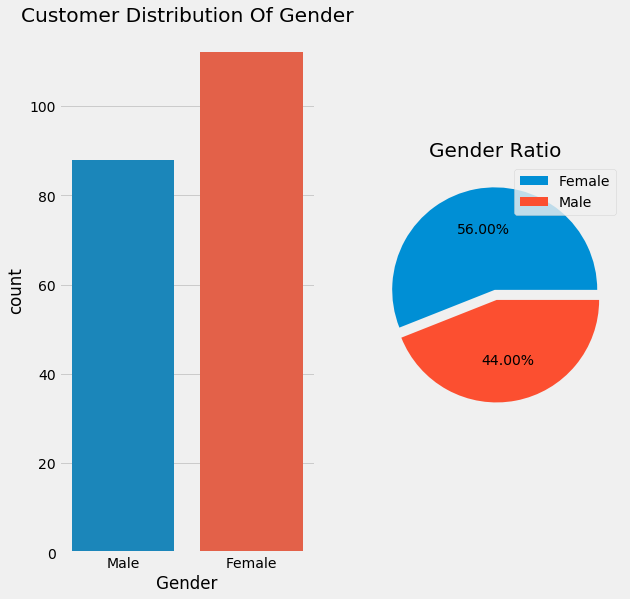

In [29]:
#plotting with countplot
plt.subplot(1,2,1)
sns.countplot(x='Gender', data=Mall_data)
plt.title('Customer Distribution Of Gender')

#plotting with pie
plt.subplot(1,2,2)
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(x=Mall_data['Gender'].value_counts(),
        explode = explode, autopct = '%.2f%%')
plt.title('Gender Ratio', fontsize = 20)
plt.legend(labels = ['Female', 'Male'], loc='best')
plt.show()

Since there was no comparability while i merely found that the Customers came to the mall tended to be a lady rather than a gentleman.I decided to Add the variables `Spending Score (1-100)` to study on:
1. Will the Male have more Consumption Power than the Female even if they have poorer numbers?

In [30]:
Gender_Score = Mall_data.groupby('Gender')['Spending Score (1-100)'].agg([np.mean, max, min])
Gender_Score

,mean,max,min
Gender,,,
Female,51.526786,99,5
Male,48.511364,97,1


From above comparison, we can know:
* One of ladies get the highest score that is 99 and one of gentlemens get the highes score which is 97.
* Even Male members accounts for 44% among the all but they still get an average score of around 48,which is only 3 scores lesser than the Female's.It shows a neck and neck Comsumption Power in men group.

* **Age & Annual Income & Spending Score (1-100)**

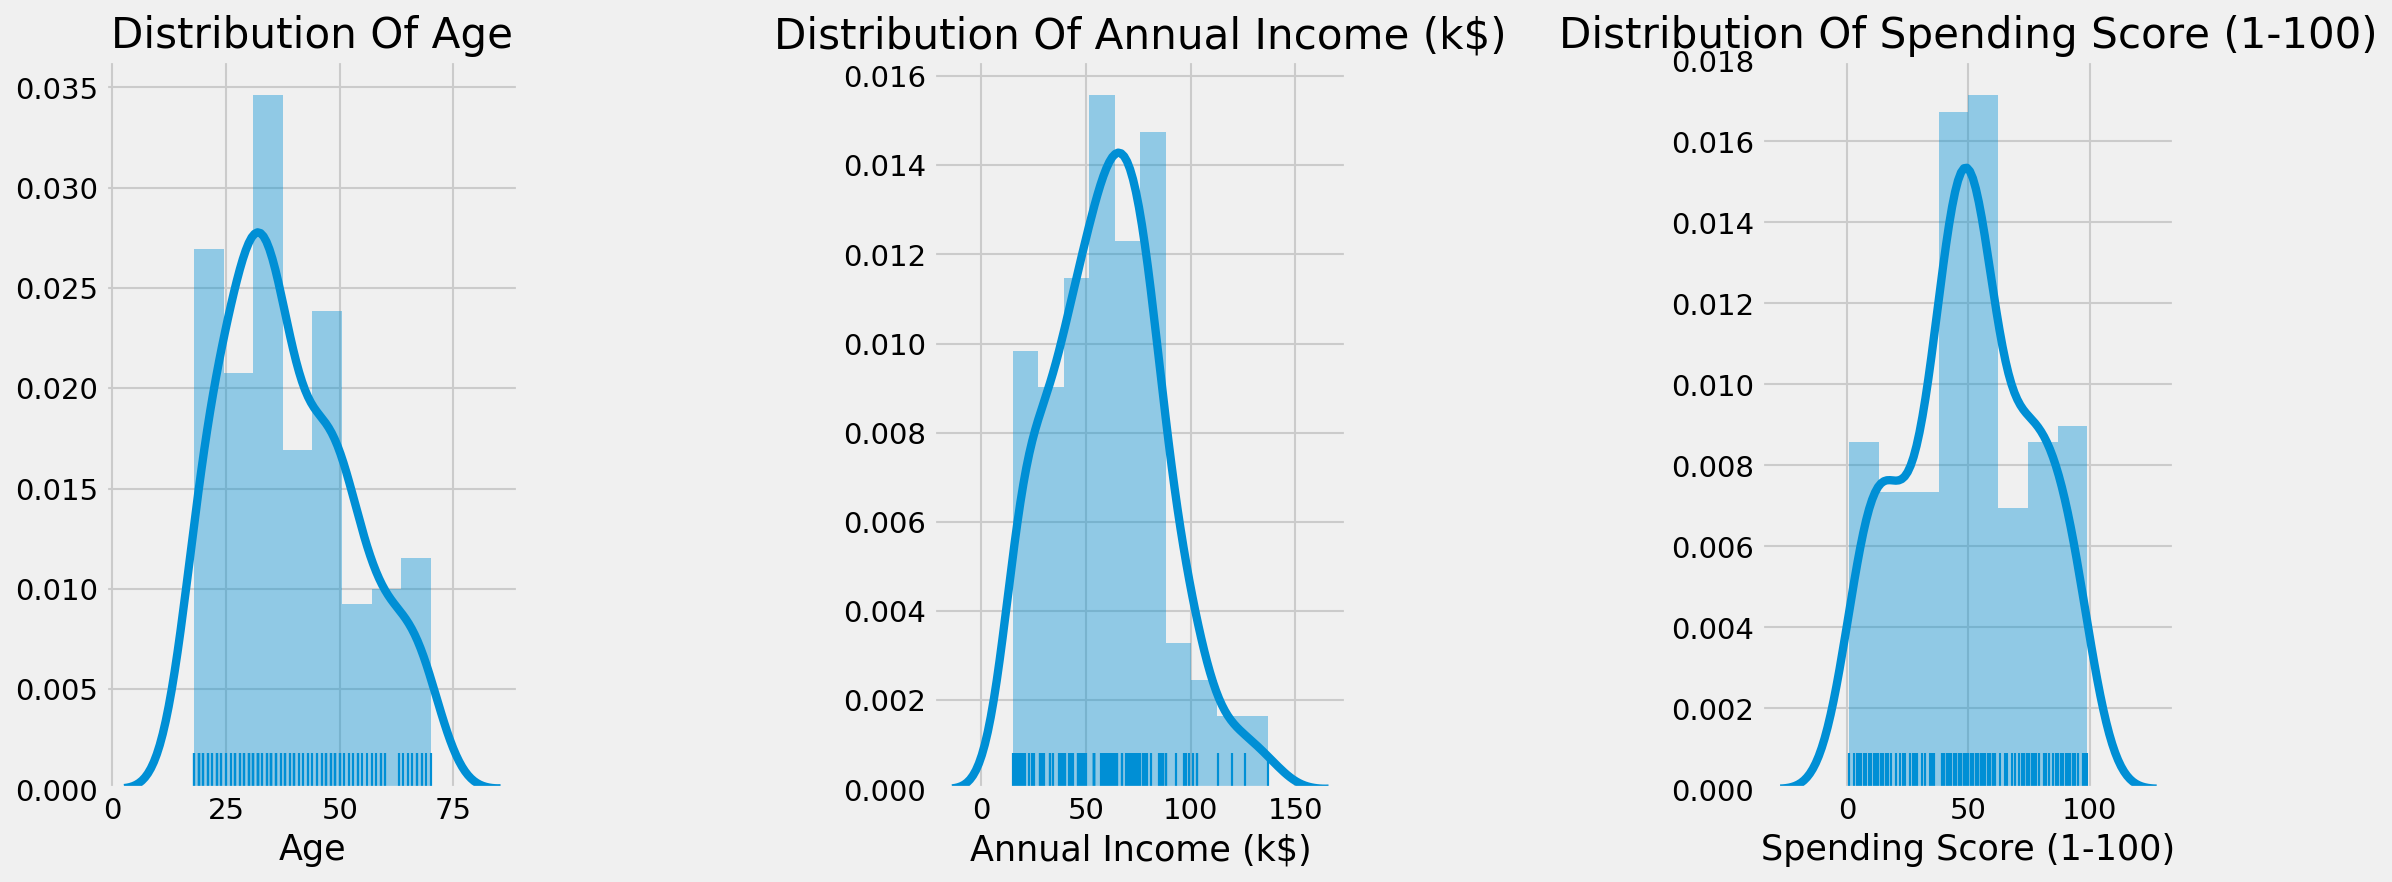

In [31]:
#Creating the figure
figure = plt.figure(figsize=(15,6), dpi=150)

#Single Variable
Features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

n=0
for i in Features:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(wspace=1, right=1)
    sns.distplot(Mall_data[i], rug=True) #rug setting the observation strip;find out data's concentration
    plt.title("Distribution Of {}".format(i))

KDE(Kernel density estimation) is used to estimate unknown density functions in probability theory.
Through plotting with the displot, the distribution characteristics of the data samples themselves can be seen relatively intuitive.

Both the Distribution seems not regular.I decided to observe under putting two variables together with pairplot

### Bivariate Plotting

* **Spending Score (1-100) & Gender**

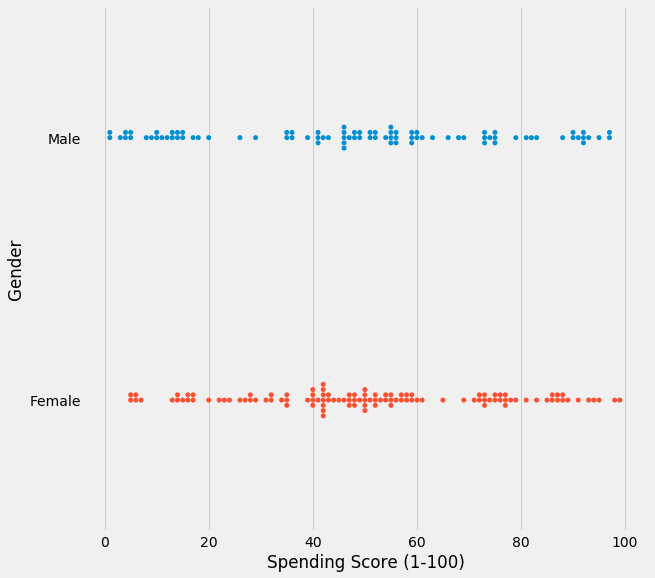

In [32]:
sns.swarmplot(data=Mall_data, x='Spending Score (1-100)', y='Gender')

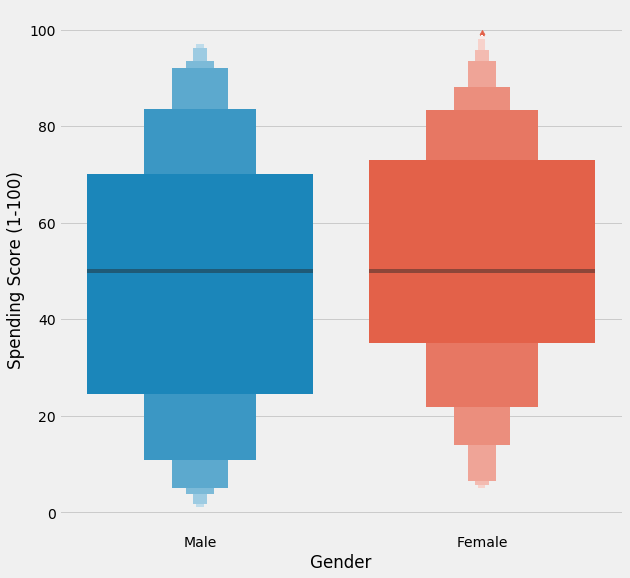

In [33]:
sns.boxenplot(data=Mall_data, x='Gender', y='Spending Score (1-100)')

From the boxenplot, An extremely red dots is on the top of the Female box, which is pretty close to the 100 score line.And it also can be seen that both the group have the same median,which is 50.The majority of Female group get better score than the male's.It suggests us that female is still the main contributors for a shopping mall.

* **Age & Annual Income (k$)**

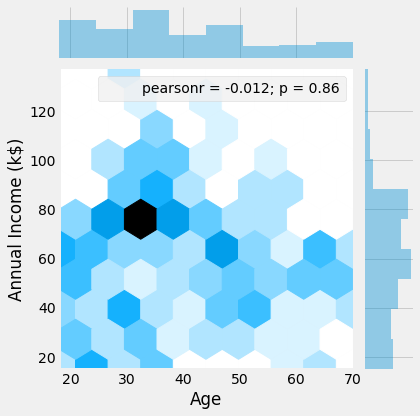

In [34]:
sns.jointplot(x='Age', y='Annual Income (k$)', data=Mall_data, kind='hex', stat_func=sci.pearsonr, ratio=5)

[About pearsonr & p](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html)

* Annual Income (k$) & Spending Score (1-100)

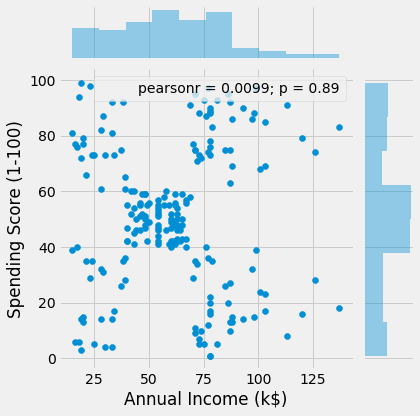

In [35]:
sns.jointplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
              data=Mall_data, stat_func=sci.pearsonr, kind='scatter')

Since the pearsonr is closed to O, which means they have poor corelation.

### Mutilvariate Plotting

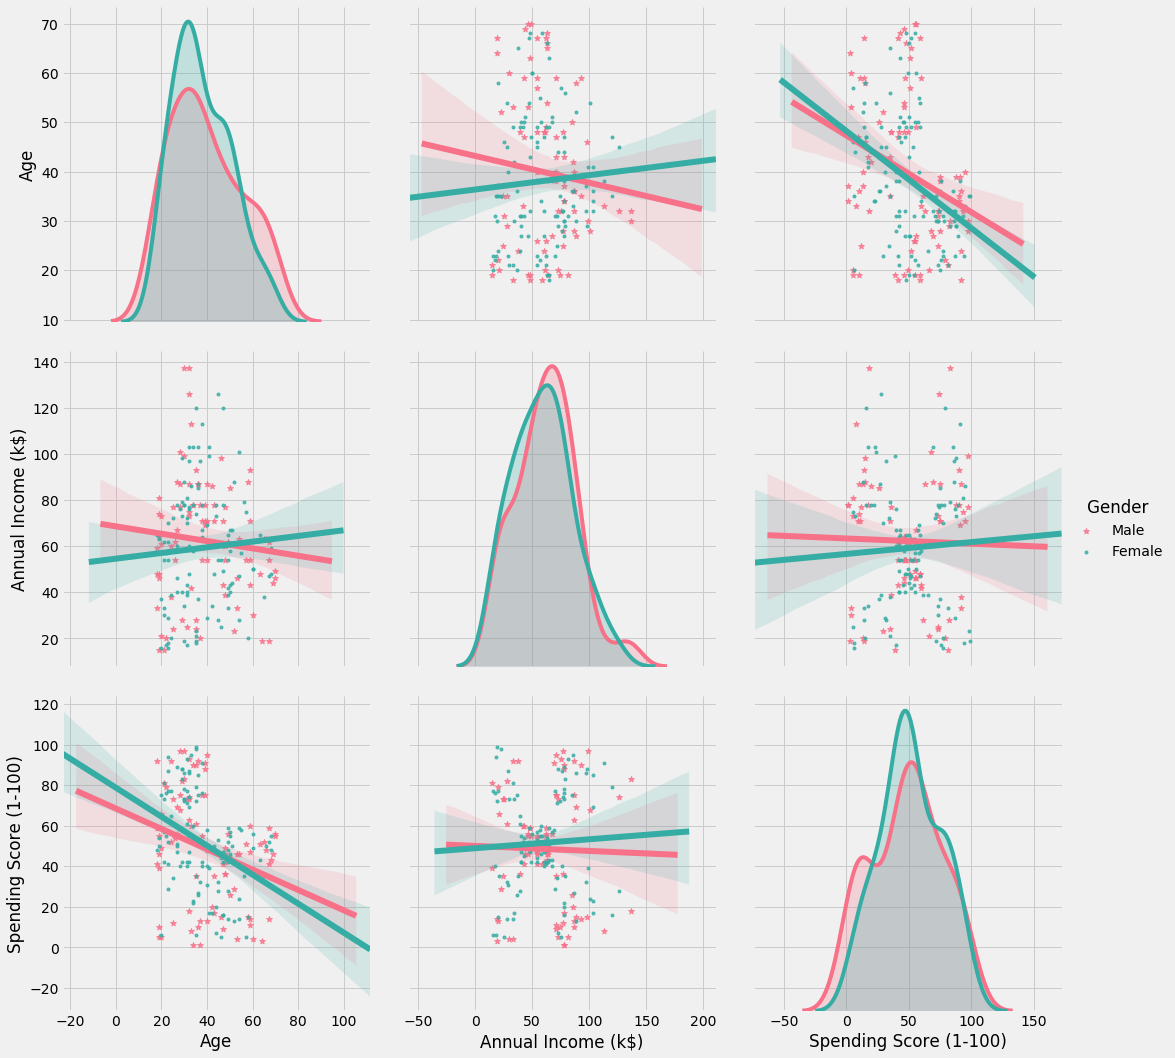

In [36]:
sns.pairplot(data=Mall_data, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], \
             hue='Gender', kind='reg', diag_kind='kde', markers=['*','.'], size=5, palette='husl')

From the above visualization, it can be known that the relationship between different variables doesn't show particular strong hint.So, in the next step, i consider try using different features combination to do the clustering.

## Clusting by K-means

The core task of KMeans is to find the `K` optimal centroids according to our K set, and assign the data closest to these centroids to the clusters represented by these centroids. The specific process can be summarized as follows:
1. Extracting No. of k samples as the initial centroid randomly.
2. Start to loop.
3. Assign each sample point to the centroid closest to them, generating k clusters.
4. For each cluster, calculating the average of all sample points assigned to the cluster as the new centroid.
5. When the position of the centroid no longer changes, the iteration stops and the clustering is completed.

### About data preprocessing

In the forum, i noticed a kaggler said about the data should be standardlized before inputting into k-means.Actually there is no argument that we should do the data preprocessing before using the algorithms.But if we are take more look at the dataset itself, we can notice that Both the `Age`,`Spending Score (1-100)` and `Annual Income(k$)` are almost on a scale of 1 to 100.

### Features Selecting

Since unsupervised algorithms only require the feature matrix X during training and do not require tags.

In [37]:
X1_Matrix = Mall_data.iloc[:, [2,4]].values # Age & Spending Score
X2_Matrix = Mall_data.iloc[:, [3,4]].values # Annual Income & Spending Score

### Clusting and Evaluating

### - Evaluating By Inertia

The goal of KMeans is to ensure that “the differences within the cluster are small as possible and the differences outside the cluster are large as possible”, and we can measure the effect of clustering by measuring intra-cluster differences. As we said earlier, Inertia is a measure of the difference within a cluster using distance. So, can we use Inertia as a measure of clustering?

1. Firstly, the smaller inertia is the better, but it is hard to recognize if a smaller inertia has reached **the limit** of the model and can continue to improve.
2. Secondly, its calculation is **too easy to receive the influence of the number of features**. When the data dimension is large, the calculation amount of inertia will fall into the curse of the dimension, and **the calculation will be unimaginably huge**, which is not suitable for evaluating the model.

#### 1.Depending on Age & Spending Score

In [38]:
inertias_1 = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=300, n_init=10,
                   random_state=0)
    kmeans.fit(X1_Matrix)
    inertia = kmeans.inertia_
    inertias_1.append(inertia)
    print('For n_cluster =', i, 'The inertia is:', inertia)

For n_cluster = 1 The inertia is: 171535.5
For n_cluster = 2 The inertia is: 75949.15601023017
For n_cluster = 3 The inertia is: 45840.67661610867
For n_cluster = 4 The inertia is: 28165.58356662934
For n_cluster = 5 The inertia is: 23811.52352472089
For n_cluster = 6 The inertia is: 19502.407839362204
For n_cluster = 7 The inertia is: 15598.876804915515


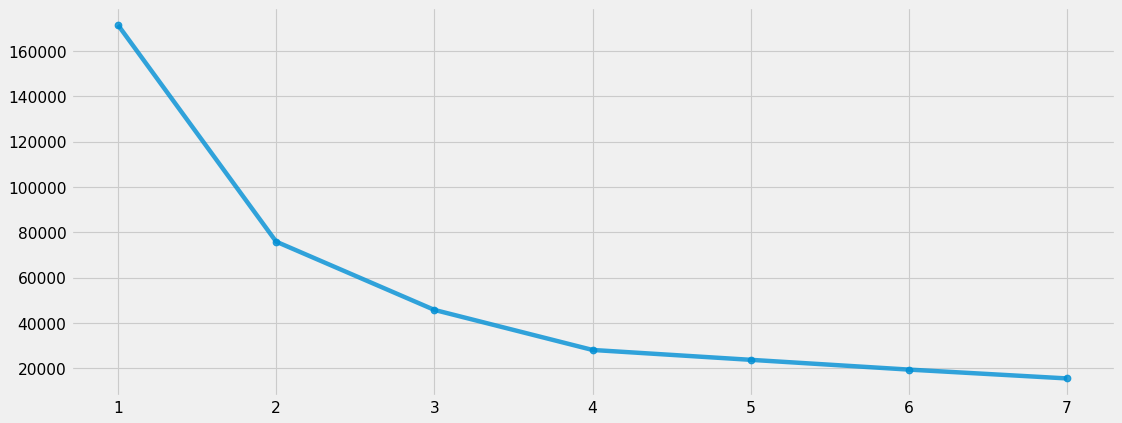

In [39]:
# Creating the figure
figure = plt.figure(1, figsize=(15,6), dpi=80)

plt.plot(np.arange(1,8), inertias_1, alpha=0.8, marker='o')

The inertia is getting lower with the increase of variable `n_clusters`.As we said, it's hard to select the optimal `k` for our model.Then, i choose to set the `n_clusters=5` and check the result.

In [40]:
Kmeans = KMeans(n_clusters=5, init='k-means++',  max_iter=300, n_init=10,
                   random_state=0)
labels = Kmeans.fit_predict(X1_Matrix)

In [41]:
centroids1 = Kmeans.cluster_centers_ # the centroid points in each cluster

Next i will visualize the cluster and make recomendations on sales strategy by renaming the cluster name.

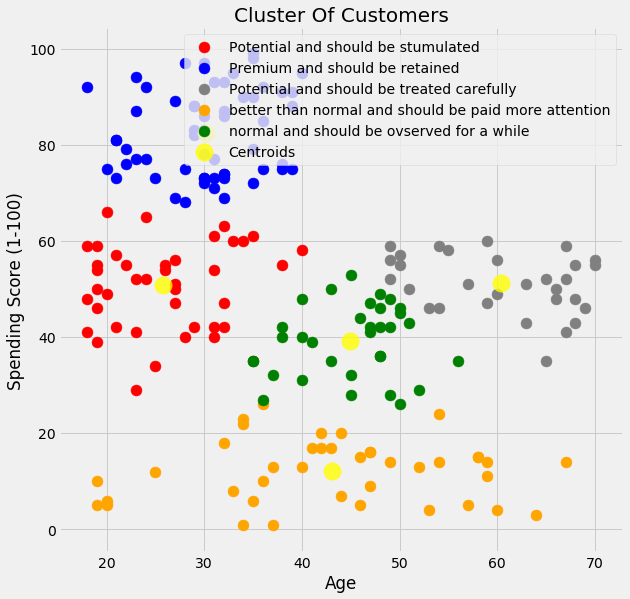

In [42]:
# Visualizing the 5 clusters
plt.scatter(x=X1_Matrix[labels==0, 0], y=X1_Matrix[labels==0, 1], s=120, c='red', label='Potential and should be stumulated')
plt.scatter(x=X1_Matrix[labels==1, 0], y=X1_Matrix[labels==1, 1], s=120, c='blue', label='Premium and should be retained')
plt.scatter(x=X1_Matrix[labels==2, 0], y=X1_Matrix[labels==2, 1], s=120, c='grey', label='Potential and should be treated carefully')
plt.scatter(x=X1_Matrix[labels==3, 0], y=X1_Matrix[labels==3, 1], s=120, c='orange', label='better than normal and should be paid more attention')
plt.scatter(x=X1_Matrix[labels==4, 0], y=X1_Matrix[labels==4, 1], s=120, c='green', label='normal and should be ovserved for a while')

#Visualizing every centroids in different cluster.
plt.scatter(x=centroids1[:,0], y=centroids1[:,1], s=300, alpha=0.8, c='yellow', label='Centroids')

#Style Setting
plt.title("Cluster Of Customers", fontsize=20)
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.legend(loc=0)

In [43]:
pd.Series(labels).value_counts()

1    57
3    40
0    40
4    33
2    30
dtype: int64

From the clusting, i find that the cunsumper expenditures vary by age.Nevertheless, Young guys have a great consumption power nowadays.The clusters of **blue** is the largest cluster,which should be treated closely and well retained.Besides, Both the clusters of **orange and red** have the same sample and different from the age group.The peple in **orange** group widely spread in age spend relatively lower in this segmentation.But the dataset didn't mention about the record time and period.So i suggest to oveserve for a while and poll out some survey to understand why the score are so low in this group.The group of **grey** are the lowest throng and the normal number group green have slightly higher than the grey group.

#### 2.Depending on Annual Income & Spending Score

In [44]:
inertias_2 = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=300, n_init=10,
                   random_state=1)
    kmeans.fit(X2_Matrix)
    inertia = kmeans.inertia_
    inertias_2.append(inertia)
    print('For n_cluster =', i, 'The inertia is:', inertia)

For n_cluster = 1 The inertia is: 269981.28
For n_cluster = 2 The inertia is: 181363.59595959596
For n_cluster = 3 The inertia is: 106348.37306211118
For n_cluster = 4 The inertia is: 73679.78903948834
For n_cluster = 5 The inertia is: 44448.45544793371
For n_cluster = 6 The inertia is: 37233.81451071001
For n_cluster = 7 The inertia is: 30566.451130251862


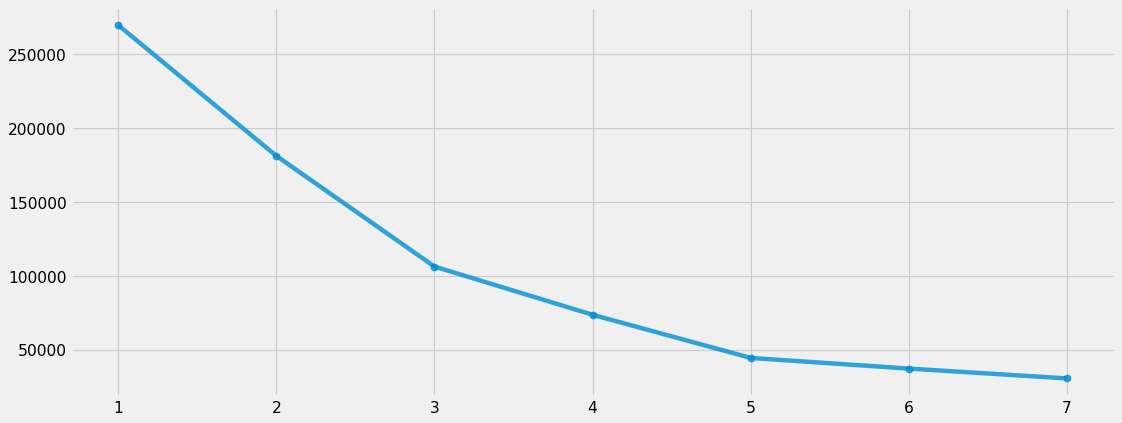

In [45]:
# Creating the figure
figure = plt.figure(1, figsize=(15,6), dpi=80)

plt.plot(np.arange(1,8), inertias_2, alpha=0.8, marker='o')

In [46]:
Kmeans = KMeans(n_clusters=5, init='k-means++',  max_iter=300, n_init=10,
                   random_state=1)
labels = Kmeans.fit_predict(X2_Matrix)

In [47]:
centroids2 = Kmeans.cluster_centers_ # the centroid points in each cluster

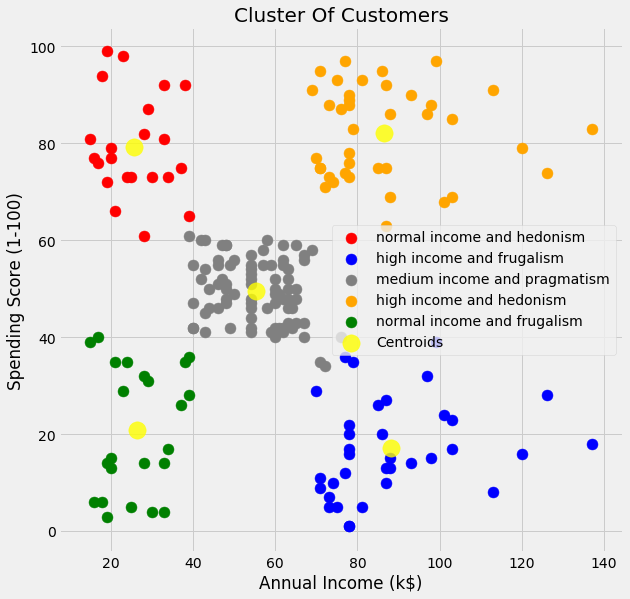

In [48]:
# Visualizing the 5 clusters
plt.scatter(x=X2_Matrix[labels==0, 0], y=X2_Matrix[labels==0, 1], s=120, c='red', label='normal income and hedonism')
plt.scatter(x=X2_Matrix[labels==1, 0], y=X2_Matrix[labels==1, 1], s=120, c='blue', label='high income and frugalism')
plt.scatter(x=X2_Matrix[labels==2, 0], y=X2_Matrix[labels==2, 1], s=120, c='grey', label='medium income and pragmatism')
plt.scatter(x=X2_Matrix[labels==3, 0], y=X2_Matrix[labels==3, 1], s=120, c='orange', label='high income and hedonism')
plt.scatter(x=X2_Matrix[labels==4, 0], y=X2_Matrix[labels==4, 1], s=120, c='green', label='normal income and frugalism')

#Visualizing every centroids in different cluster.
plt.scatter(x=centroids2[:,0], y=centroids2[:,1], s=300, alpha=0.8, c='yellow', label='Centroids')

#Style Setting
plt.title("Cluster Of Customers", fontsize=20)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(loc=7)

According to the result shown above, all of the group have the apparent Segmentation.I classified into 5 clusters and define them based on the `Annual Income & Spending Score` of different level(**Based on income,i would describe like normal/medium/high income.Based on Spending Score, i would describe like the hedonism, frugalism and pragmatism)**.

No matter what I suggest that the customers should not be ignored simply because they spend less on the mall or they don't have a relatively high level of income.We should take different kinds of meseaure(like promotion on some specific commodity or discount) to stumalate the consumers and make them buy things at pleasure.And all the measure can be taken before taking consideration on recording whay types of commodity they bought in the past.

### - Evaluating By Silhouette Score 

The last section i use the innertia to evaluate how many clusters should be divided for the best and dicuss about why it's not the best choice to use inertia.So, why we prefer to use Silhouette Score?

It can measure at the same time:
1. The similarity a of the sample to other samples in the cluster in which it is located is equal to the average distance between the sample and all other points in the same cluster
2. The similarity b between the sample and the samples in other clusters is equal to the average distance between the sample and all the points in the next nearest cluster. According to the requirements of the cluster, the difference within the cluster should be small, and the difference outside the cluster should be large. b is always greater than a, and the more you grow, the better.

**S = b-a/max(a,b) >>> S = 1-a/b,if a<b  |  S=0,if a=b   | S=b/a-1 if a>b**

It is easy to understand that the range of **Silhouette Score is (-1,1)**.If the value is closer to 1, It means that the sample is very similar to the sample within the same cluster, but is not similar to the sample points where it is outside the cluster.

When the samples are similar to the samples which is not in the same cluster, the Silhouette Score wile be negative. 

When the Silhouette Score is about to 0, it means that the similarity of the samples in the two clusters is the same, and it could be said the two clusters should be the one cluster.

**Two situation about the Silhouette Score:**

If most of the samples in a cluster have relatively **high** Silhouette Score, then the clusters will have a high Silhouette Score,which results in higher mean Silhouette Score.And this the clustering is reasonable. 

If many sample points have relatively **low** Silhouette Score or even show negative values.It means that the clustering is not appropriate, and the cluster's hyperparameter `K may be set too large or too small`.

In [49]:
for n_clusters in range(3,8):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X2_Matrix)
    clusters = kmeans.predict(X2_Matrix)
    silhouette_avg = silhouette_score(X2_Matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5393922132561455
For n_clusters = 7 The average silhouette_score is : 0.5264283703685728


Obviously, the average Silhouette Score is 0.55 for n_cluster=5, which is more close to the 1.Compared with using `inertia` to find the best `K`, Is this not a better way to identify how many clusters should we make?

Finally, i check how many samples in each cluster:

In [50]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(X2_Matrix)
clusters = kmeans.predict(X2_Matrix)
silhouette_avg = silhouette_score(X2_Matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.553931997444648


In [51]:
pd.Series(clusters).value_counts()

0    81
2    39
1    35
4    23
3    22
dtype: int64

#### It's so nice to get some opinions,please feel free to tell me.And if you like my work, please upvote it.~